# Demographic predictors of birth counts in US counties from 2011-2020

In this notebook we will explore predictors of natality, defined here as birth count per county/year, for a subset of US counties between 2011 and 2020.  

In [1]:
import pandas as pd
import numpy as np
from prep import births, demog, pop, na, age_groups, rucc
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

View some of the raw data:

In [2]:
births.head()

,County,FIPS,Births,year
0,"Baldwin County, AL",01003,2157.0,2011
1,"Calhoun County, AL",01015,1418.0,2011
2,"Etowah County, AL",01055,1173.0,2011
3,"Jefferson County, AL",01073,8916.0,2011
4,"Lee County, AL",01081,1536.0,2011


In [3]:
pop.head()

,FIPS,Population
0,01001,56928
1,01003,209796
2,01005,26302
3,01007,22652
4,01009,58209


In [4]:
rucc.head()

,FIPS,RUCC_2013
0,01001,2.0
1,01003,3.0
2,01005,6.0
3,01007,1.0
4,01009,1.0


In [5]:
demog.head()

,W_N_M_0,W_N_M_1,W_N_M_2,W_N_M_3,W_N_M_4,W_N_M_5,W_N_M_6,W_N_M_7,W_N_M_8,W_N_M_9,...,N_H_M_17,A_H_F_13,B_H_M_18,N_H_F_17,A_H_M_17,N_H_M_15,A_H_F_18,N_H_M_18,N_H_F_18,A_H_M_16
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,242.0,981.0,1403.0,1482.0,1522.0,1268.0,1301.0,1278.0,1335.0,1441.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01003,912.0,3690.0,4929.0,5467.0,5236.0,4437.0,4565.0,4681.0,5083.0,5311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,42.0,201.0,273.0,279.0,321.0,368.0,419.0,388.0,409.0,455.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,108.0,353.0,506.0,574.0,547.0,482.0,565.0,545.0,564.0,615.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01009,268.0,1131.0,1518.0,1583.0,1700.0,1470.0,1447.0,1366.0,1533.0,1574.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a dataframe for modeling.  Merge the birth data with population and RUCC data.

In [6]:
da = pd.merge(births, pop, on="FIPS", how="left")
da = pd.merge(da, rucc, on="FIPS", how="left")

Population will be used as an offset below.

In [7]:
da["logPop"] = np.log(da["Population"])
da = da.dropna()
da["yearc"] = da["year"] - da["year"].mean()
da["logPopc"] = da["logPop"] - da["logPop"].mean()
da["RUCC_2013c"] = da["RUCC_2013"] - da["RUCC_2013"].mean()

## Scaling by population size and offsets

It is natural to expect a 1-1 scaling between total population size and the number of births.  That is, all else equal we would expect two counties that differ by a factor of two in population size to differ by two in natality.  To assess this, we can make a scatterplot of the birth count versus the population size in log-space.  Under the expected 1-1 scaling, the slope of this line should be close to 1.

In [8]:
da = da.sort_values(["FIPS", "year"])
da.head()

,County,FIPS,Births,year,Population,RUCC_2013,logPop,yearc,logPopc,RUCC_2013c
0,"Baldwin County, AL",01003,2157.0,2011,209796,3.0,12.253891,-4.600926,-0.3339,1.124066
524,"Baldwin County, AL",01003,2109.0,2012,209796,3.0,12.253891,-3.600926,-0.3339,1.124066
1048,"Baldwin County, AL",01003,2160.0,2013,209796,3.0,12.253891,-2.600926,-0.3339,1.124066
1572,"Baldwin County, AL",01003,2244.0,2014,209796,3.0,12.253891,-1.600926,-0.3339,1.124066
2150,"Baldwin County, AL",01003,2344.0,2015,209796,3.0,12.253891,-0.600926,-0.3339,1.124066


1.0318998942816398

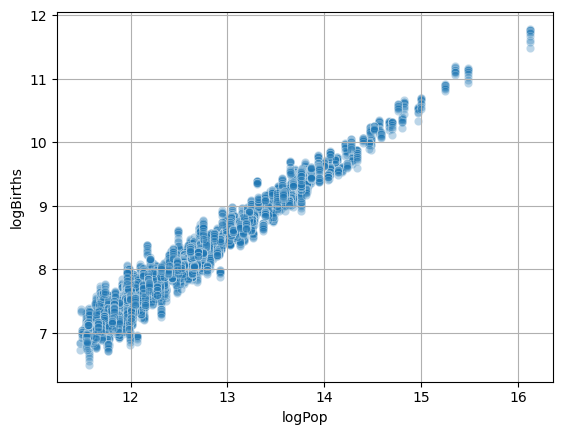

In [9]:
da["logBirths"] = np.log(da["Births"])
sns.scatterplot(da, x="logPop", y="logBirths", alpha=0.3)
plt.grid(True)
b = np.cov(da["logPop"], da["logBirths"])[0, 1] / np.var(da["logPop"])
b

## Assessing the variance structure and mean/variance relationships

Since we have 10 years of data for each county, we can treat these as replicates to estimate the mean and variance within each county (over the 10 years covered by the dataset).  This is one way for us to assess the mean/variance relationship.

In [10]:
mv = births.groupby("FIPS")["Births"].agg([np.mean, np.var])
lmv = np.log(mv)
mv

,mean,var
FIPS,,
01003,2249.400000,6699.600000
01015,1335.600000,3090.711111
01055,1190.100000,804.100000
01069,1323.714286,751.904762
01073,8650.800000,100633.288889
...,...,...
55117,1237.000000,3276.222222
55127,961.571429,6687.952381
55131,1308.200000,3390.400000


Regress log variance on log mean

In [11]:
mr = sm.OLS.from_formula("var ~ mean", lmv).fit()
print(mr.summary())

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2042.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          7.38e-192
Time:                        10:36:32   Log-Likelihood:                -735.05
No. Observations:                 580   AIC:                             1474.
Df Residuals:                     578   BIC:                             1483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4898      0.338    -16.231      0.0

Plot the log variance against the log mean.  If variance = phi * mean, then log(variance) = log(phi) + log(mean), i.e. the slope is 1 and the intercept is log(phi).  If variance = phi * mean^a then log(variance) = log(phi) + a * log(mean).

Text(0, 0.5, 'Log variance')

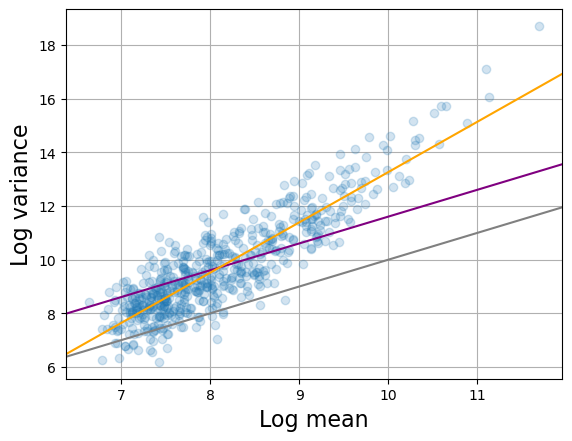

In [12]:
plt.clf()
plt.grid(True)
plt.plot(lmv["mean"], lmv["var"], "o", alpha=0.2, rasterized=True)
plt.axline((8, 8), slope=1, color="grey")
plt.axline((lmv["mean"].mean(0), lmv["var"].mean(0)), slope=1, color="purple")
plt.axline((8, mr.params[0]+8*mr.params[1]), slope=mr.params[1], color="orange")
plt.xlabel("Log mean", size=16)
plt.ylabel("Log variance", size=16)

## Urbanicity and time trends as predictors of natality

Below we fit a GLM, which is not appropriate since we have repeated measures on counties.  Specifically, the uncertainty assessments (standard errors, p-values, confidence intervals, score tests) will be invalid, but the point estimates of the coefficients are still meaningful.

In [13]:
fml = "Births ~ logPop + RUCC_2013"
m0 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r0 = m0.fit() # Poisson
r0x = m0.fit(scale="X2") # Quasi-Poisson
r0x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Births   No. Observations:                 5618
Model:                            GLM   Df Residuals:                     5615
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          133.26
Method:                          IRLS   Log-Likelihood:                -2976.6
Date:                Wed, 30 Oct 2024   Deviance:                   7.3730e+05
Time:                        10:36:33   Pearson chi2:                 7.48e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9352      0.035   -139.888      0.000      -5.004      -4.866
logPop         1.0354      0.002    444.760      0.000       1.031       1.040
RUCC_2013      0.0280      0.004      7.249      0.000       0.020       0.036
==============================================================================
"""

Using GEE accounts for the correlated data

In [14]:
m1 = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Poisson(), data=da)
r1 = m1.fit() # Poisson and quasi-Poisson are the same for GEE
r1x = m1.fit(scale="X2")
r1x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 30 Oct 2024   Scale:                         133.257
Covariance type:                    robust   Time:                         10:36:33
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9352      0.189    -26.069      0.000      -5.306      -4.564
logPop         1.0354      0.013     77.925      0.000       1.009       1.061
RUCC_2013      0.0280      0.014      2.063      0.039       0.001       0.055
==============================================================================
Skew:                         -4.2322   Kurtosis:                     131.8250
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Use log population as an offset instead of a covariate

In [15]:
m2 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         family=sm.families.Poisson(), data=da)
r2 = m2.fit(scale="X2")
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 30 Oct 2024   Scale:                         138.265
Covariance type:                    robust   Time:                         10:36:33
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4046      0.019   -231.734      0.000      -4.442      -4.367
RUCC_2013     -0.0073      0.010     -0.711      0.477      -0.027       0.013
==============================================================================
Skew:                          1.3239   Kurtosis:                      55.1011
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Below we construct a diagnostic plot for the variance structure that does not require there to be replicates  (in general there will be no replicates, and even here it is unclear whether we can treat the 10 years of data within each county as replicates).  If the variance structure is correctly specified, then the absolute Pearson residuals should have constant conditional mean (no trend) with respect to the fitted values.

Text(0, 0.5, 'Absolute Pearson residual')

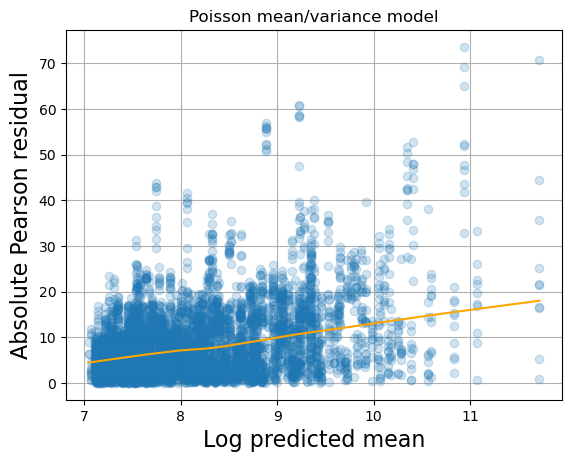

In [16]:
plt.clf()
plt.grid(True)
lfv = np.log(r2.fittedvalues).values
apr = np.abs(r2.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Poisson mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

The Poisson variance model did not fit well based on the diagnostic above, so we next consider a Gamma family to better match the mean/variance relationship.

In [17]:
m3 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r3 = m3.fit(scale="X2")
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 30 Oct 2024   Scale:                           0.033
Covariance type:                    robust   Time:                         10:36:33
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4521      0.016   -284.946      0.000      -4.483      -4.421
RUCC_2013      0.0055      0.008      0.669      0.503      -0.011       0.022
==============================================================================
Skew:                          3.4604   Kurtosis:                      45.8490
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Diagnostic plot for mean/variance relationship with gamma model.

Text(0, 0.5, 'Absolute Pearson residual')

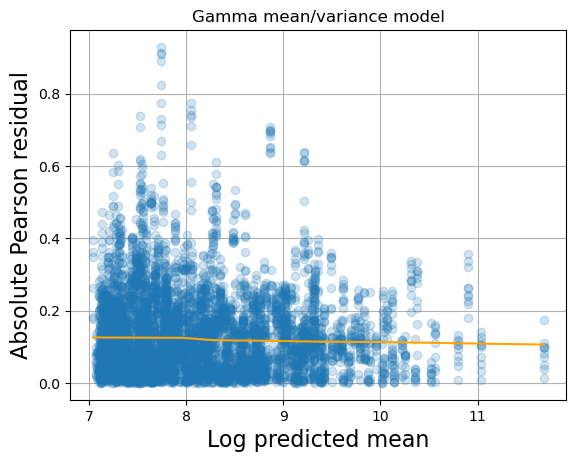

In [18]:
plt.clf()
plt.grid(True)
lfv = np.log(r3.fittedvalues).values
apr = np.abs(r3.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Gamma mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

Now we proceed to fit and interpret some regression models.  Here we use exchangeable correlation structure in the GEE.  Since RUCC is constant within groups the parameter estimates and standard errors are the same as with the independence model.  The first model only considers the role of urbanicity (RUCC).

In [19]:
m4 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r4 = m4.fit(scale="X2")
r4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Wed, 30 Oct 2024   Scale:                           0.033
Covariance type:                    robust   Time:                         10:36:34
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4508      0.016   -286.202      0.000      -4.481      -4.420
RUCC_2013      0.0053      0.008      0.652      0.514      -0.011       0.021
==============================================================================
Skew:                          3.4076   Kurtosis:                      45.9654
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Now we consider the role of urbanicity as well as the potential for a linear time trend.

In [20]:
m5 = sm.GEE.from_formula("Births ~ RUCC_2013 + year", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r5 = m5.fit(scale="X2")
r5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Wed, 30 Oct 2024   Scale:                           0.032
Covariance type:                    robust   Time:                         10:36:34
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0686      0.916     12.090      0.000       9.274      12.863
RUCC_2013      0.0054      0.008      0.654      0.513      -0.011       0.021
year          -0.0077      0.000    -16.967      0.000      -0.009      -0.007
==============================================================================
Skew:                          3.8424   Kurtosis:                      42.5273
Centered skew:                -8.8976   Centered kurtosis:            411.0351
==============================================================================
"""

Now we consider the possibility that the linear time trend is different based on the level of urbanicity.

In [21]:
m6 = sm.GEE.from_formula("Births ~ RUCC_2013c * yearc", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r6 = m6.fit(scale="X2")
r6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Wed, 30 Oct 2024   Scale:                           0.032
Covariance type:                    robust   Time:                         10:36:34
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.4407      0.007   -610.930      0.000      -4.455      -4.426
RUCC_2013c           0.0056      0.008      0.675      0.500      -0.011       0.022
yearc               -0.0077      0.000    -17.345      0.000      -0.009      -0.007
RUCC_2013c:yearc    -0.0027      0.000     -5.590      0.000      -0.004      -0.002
==============================================================================
Skew:                          3.7249   Kurtosis:                      43.3159
Centered skew:                -8.9523   Centered kurtosis:            424.4807
==============================================================================
"""

Score tests comparing pairs of nested models:

In [22]:
print(r5.model.compare_score_test(r4))
print(r6.model.compare_score_test(r5))

{'statistic': 181.47386859557557, 'df': 1, 'p-value': 0.0}
{'statistic': 26.513774966742297, 'df': 1, 'p-value': 2.616655997433881e-07}


## Principal Components Regression

We begin by double centering the demographic data.

In [23]:
demogx = np.asarray(demog)
demogx = np.log(1 + demogx)
demogx -= demogx.mean()
demogx -= demogx.mean(0)
demogx -= demogx.mean(1)[:, None]
demog

,W_N_M_0,W_N_M_1,W_N_M_2,W_N_M_3,W_N_M_4,W_N_M_5,W_N_M_6,W_N_M_7,W_N_M_8,W_N_M_9,...,N_H_M_17,A_H_F_13,B_H_M_18,N_H_F_17,A_H_M_17,N_H_M_15,A_H_F_18,N_H_M_18,N_H_F_18,A_H_M_16
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,242.0,981.0,1403.0,1482.0,1522.0,1268.0,1301.0,1278.0,1335.0,1441.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01003,912.0,3690.0,4929.0,5467.0,5236.0,4437.0,4565.0,4681.0,5083.0,5311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,42.0,201.0,273.0,279.0,321.0,368.0,419.0,388.0,409.0,455.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,108.0,353.0,506.0,574.0,547.0,482.0,565.0,545.0,564.0,615.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01009,268.0,1131.0,1518.0,1583.0,1700.0,1470.0,1447.0,1366.0,1533.0,1574.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,234.0,968.0,1299.0,1298.0,1201.0,1059.0,1252.0,1427.0,1409.0,1148.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
56039,91.0,354.0,465.0,433.0,369.0,383.0,923.0,923.0,845.0,793.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
56041,135.0,554.0,791.0,793.0,711.0,476.0,490.0,620.0,637.0,579.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


Get factors (principal components) from the demographic data.

In [24]:
u, s, vt = np.linalg.svd(demogx, 0)
v = vt.T

Convert the coefficients back to the original coordinates

In [25]:
def convert_coef(c, npc):
    return np.dot(v[:, 0:npc], c/s[0:npc])

Put the demographic factors into a dataframe

In [26]:
m = {("pc%02d" % k) : u[:, k] for k in range(100)}
m["FIPS"] = demog.index
demog_f = pd.DataFrame(m)

Merge demographic information into the births data

In [27]:
da = pd.merge(da, demog_f, on="FIPS", how="left")

Include this number of factors in subsequent models

In [28]:
npc = 10

A GLM, not appropriate since we have repeated measures on counties

In [29]:
fml = "Births ~ (logPopc + RUCC_2013c) * yearc + " + " + ".join(["pc%02d" % j for j in range(npc)])
m7 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r7 = m7.fit(scale="X2")
r7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Births   No. Observations:                 5618
Model:                            GLM   Df Residuals:                     5602
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          54.979
Method:                          IRLS   Log-Likelihood:                -3259.1
Date:                Wed, 30 Oct 2024   Deviance:                   3.0236e+05
Time:                        10:36:35   Pearson chi2:                 3.08e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.0761      0.007   1161.008      0.000       8.062       8.090
logPopc              1.0117      0.002    447.707      0.000       1.007       1.016
RUCC_2013c           0.0067      0.003      2.385      0.017       0.001       0.012
yearc               -0.0065      0.001    -10.246      0.000      -0.008      -0.005
logPopc:yearc       -0.0051      0.001     -9.578      0.000      -0.006      -0.004
RUCC_2013c:yearc    -0.0055      0.001     -6.290      0.000      -0.007      -0.004
pc00                -2.2696      0.185    -12.274      0.000      -2.632      -1.907
pc01                 2.5068      0.183     13.708      0.000       2.148       2.865
pc02                 2.9680      0.093     32.000      0.000       2.786       3.150
pc03                 4.0183      0.135     29.796      0.000       3.754       4.283
pc04                -0.1014      0.089     -1.137      0.256      -0.276       0.073
pc05                -3.4763      0.080    -43.555      0.000      -3.633      -3.320
pc06                -0.9278      0.121     -7.644      0.000      -1.166      -0.690
pc07                -0.8702      0.181     -4.805      0.000      -1.225      -0.515
pc08                 3.9708      0.139     28.483      0.000       3.698       4.244
pc09                -0.7064      0.069    -10.199      0.000      -0.842      -0.571
====================================================================================
"""

GEE accounts for the correlated data

In [30]:
m8 = sm.GEE.from_formula(fml, groups="FIPS",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r8 = m8.fit(scale="X2")
r8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 30 Oct 2024   Scale:                           0.013
Covariance type:                    robust   Time:                         10:36:35
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.1519      0.024    341.027      0.000       8.105       8.199
logPopc              1.0439      0.011     90.945      0.000       1.021       1.066
RUCC_2013c           0.0059      0.007      0.893      0.372      -0.007       0.019
yearc               -0.0074      0.000    -15.361      0.000      -0.008      -0.006
logPopc:yearc       -0.0022      0.001     -3.022      0.003      -0.004      -0.001
RUCC_2013c:yearc    -0.0035      0.001     -4.983      0.000      -0.005      -0.002
pc00                -1.1222      0.649     -1.728      0.084      -2.395       0.151
pc01                 0.6590      0.673      0.978      0.328      -0.661       1.979
pc02                 3.9590      0.318     12.463      0.000       3.336       4.582
pc03                 3.4809      0.446      7.803      0.000       2.607       4.355
pc04                 0.7576      0.303      2.497      0.013       0.163       1.352
pc05                -3.4547      0.293    -11.792      0.000      -4.029      -2.880
pc06                -1.6408      0.355     -4.619      0.000      -2.337      -0.945
pc07                -0.2870      0.488     -0.588      0.556      -1.244       0.670
pc08                 3.8508      0.422      9.119      0.000       3.023       4.678
pc09                -1.7549      0.245     -7.177      0.000      -2.234      -1.276
==============================================================================
Skew:                         -7.8958   Kurtosis:                     175.5423
Centered skew:                -7.7507   Centered kurtosis:            318.0523
==============================================================================
"""

Use log population as an offset instead of a covariate

In [31]:
fml = "Births ~ " + " + ".join(["pc%02d" % j for j in range(npc)])
m9 = sm.GEE.from_formula(fml, groups="FIPS", offset="logPop",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r9 = m9.fit(scale="X2")
r9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 30 Oct 2024   Scale:                           0.014
Covariance type:                    robust   Time:                         10:36:35
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4979      0.017   -271.395      0.000      -4.530      -4.465
pc00          -2.2488      0.512     -4.390      0.000      -3.253      -1.245
pc01           2.1435      0.560      3.826      0.000       1.045       3.241
pc02           3.7940      0.312     12.162      0.000       3.183       4.405
pc03           4.3196      0.393     11.003      0.000       3.550       5.089
pc04           0.2608      0.273      0.955      0.340      -0.274       0.796
pc05          -3.1767      0.286    -11.125      0.000      -3.736      -2.617
pc06          -1.4064      0.356     -3.950      0.000      -2.104      -0.709
pc07          -0.2769      0.491     -0.564      0.573      -1.240       0.686
pc08           3.4637      0.397      8.731      0.000       2.686       4.241
pc09          -1.5543      0.240     -6.467      0.000      -2.025      -1.083
==============================================================================
Skew:                         -0.3961   Kurtosis:                     107.1535
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Restructure the coefficients so that the age bands are in the columns.

In [32]:
def restructure(c):
    ii = pd.MultiIndex.from_tuples(na)
    c = pd.Series(c, index=ii)
    c = c.unstack()
    return c

This function fits a Gamma GLM to the data using 'npc' principal components as explanatory variables (using GEE to account for non-independence), then converts the coefficients back to the original variables.

In [33]:
def fitmodel(npc):
    # A GEE using log population as an offset
    fml = "Births ~ 1" if npc == 0 else "Births ~ RUCC_2013c*yearc + " + " + ".join(["pc%02d" % j for j in range(npc)])
    m = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Gamma(link=sm.families.links.log()),
                            offset=da["logPop"], data=da)
    r = m.fit(scale="X2")

    # Convert the coefficients back to the original coordinates
    c = convert_coef(r.params[4:], npc)

    # Restructure the coefficients so that the age bands are
    # in the columns.
    c = restructure(c)

    return c, m, r

Plot styling information

In [34]:
colors = {"A": "purple", "B": "orange", "N": "lime", "W": "red"}
lt = {"F": "-", "M": ":"}
sym = {"H": "s", "N": "o"}
ages = range(0, 19)

Fit models with these numbers of PCs.

In [35]:
pcs = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

<Figure size 640x480 with 0 Axes>

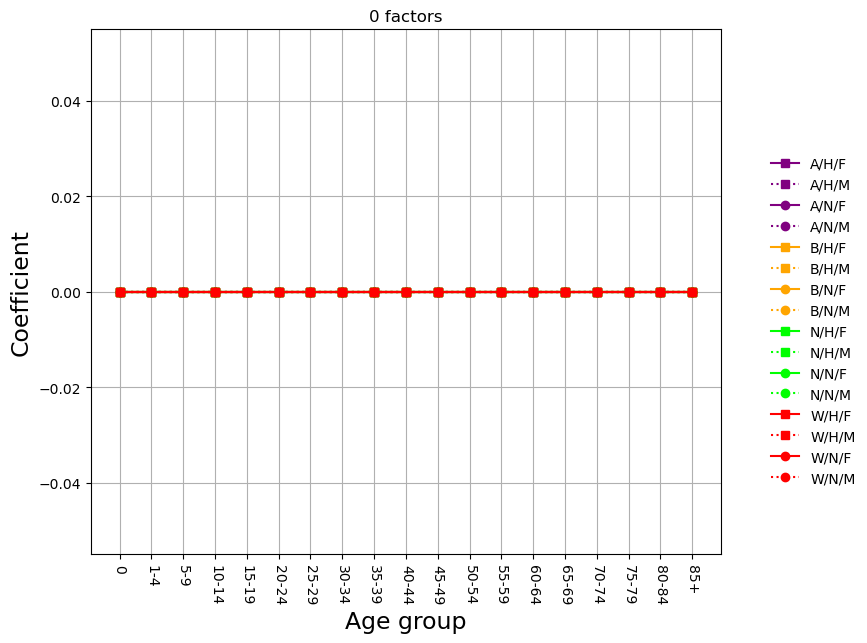

<Figure size 640x480 with 0 Axes>

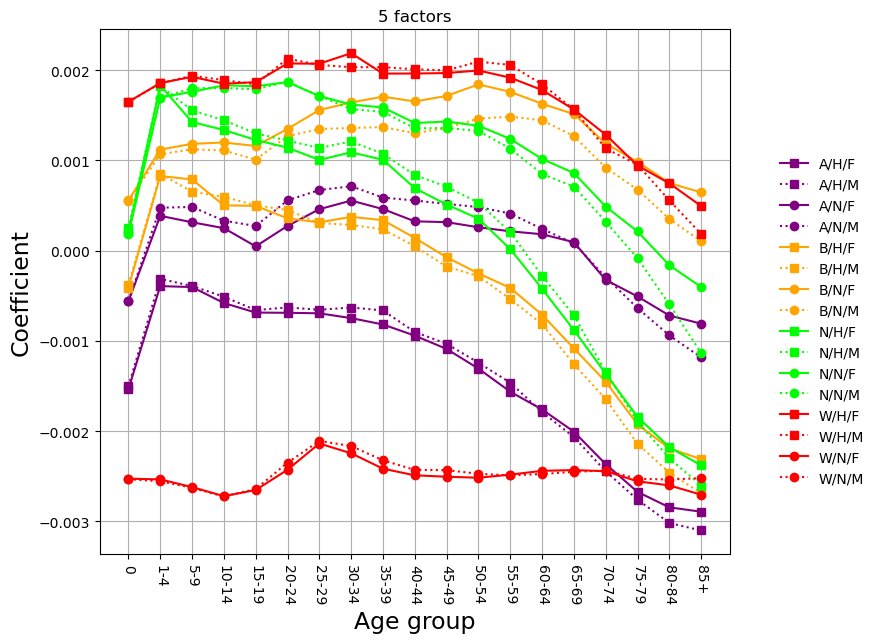

<Figure size 640x480 with 0 Axes>

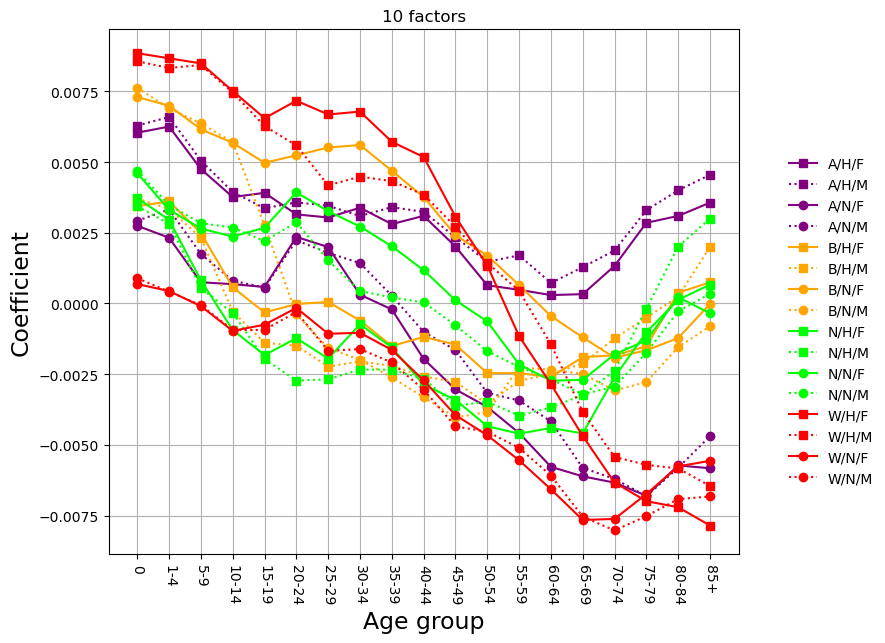

<Figure size 640x480 with 0 Axes>

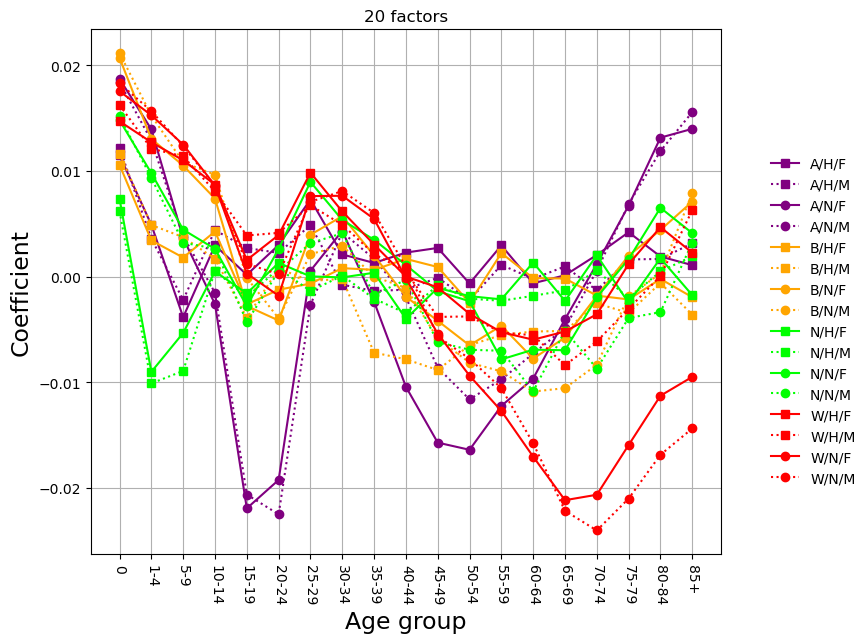

<Figure size 640x480 with 0 Axes>

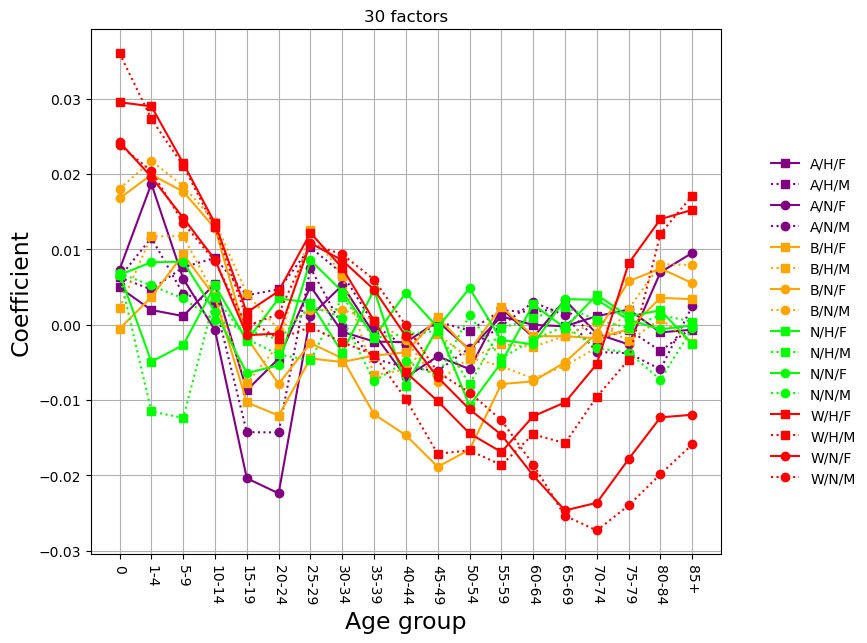

<Figure size 640x480 with 0 Axes>

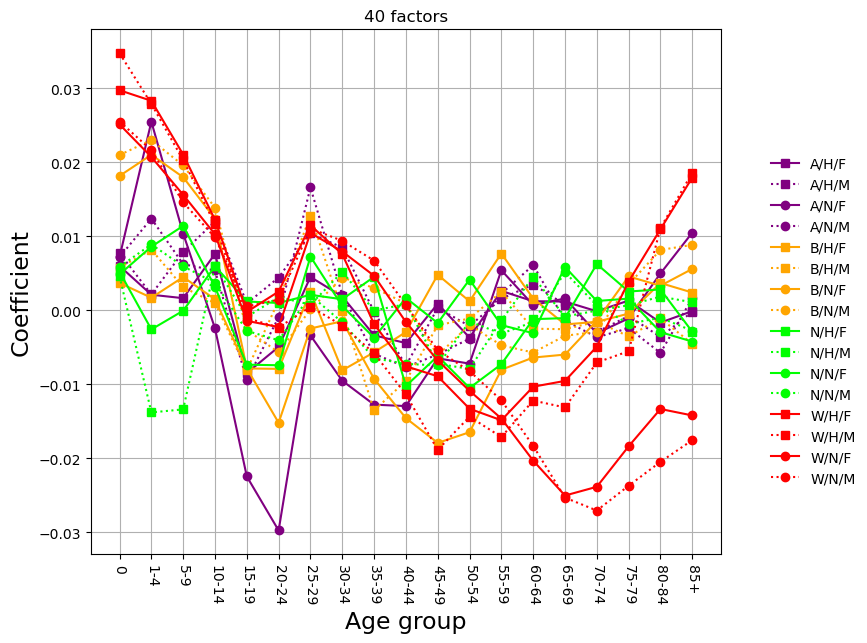

<Figure size 640x480 with 0 Axes>

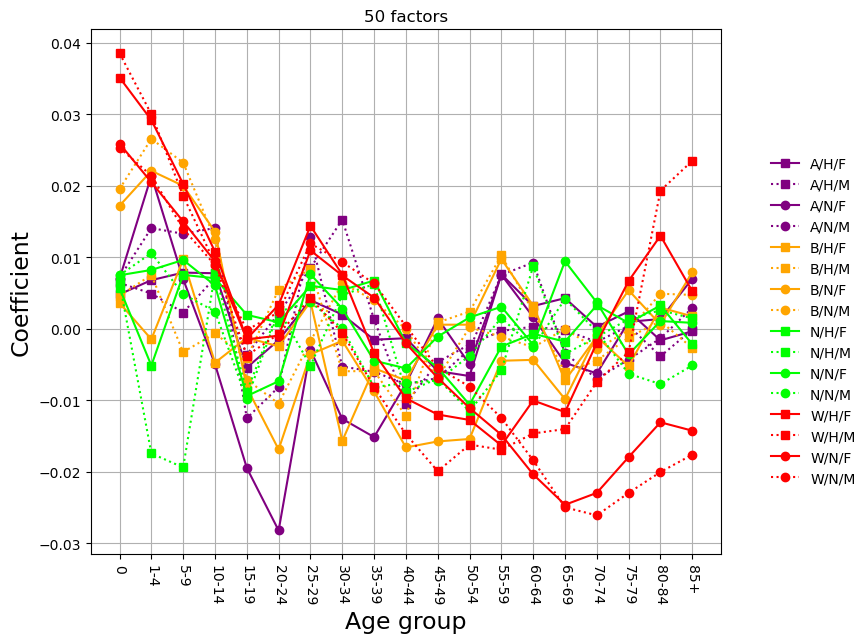

<Figure size 640x480 with 0 Axes>

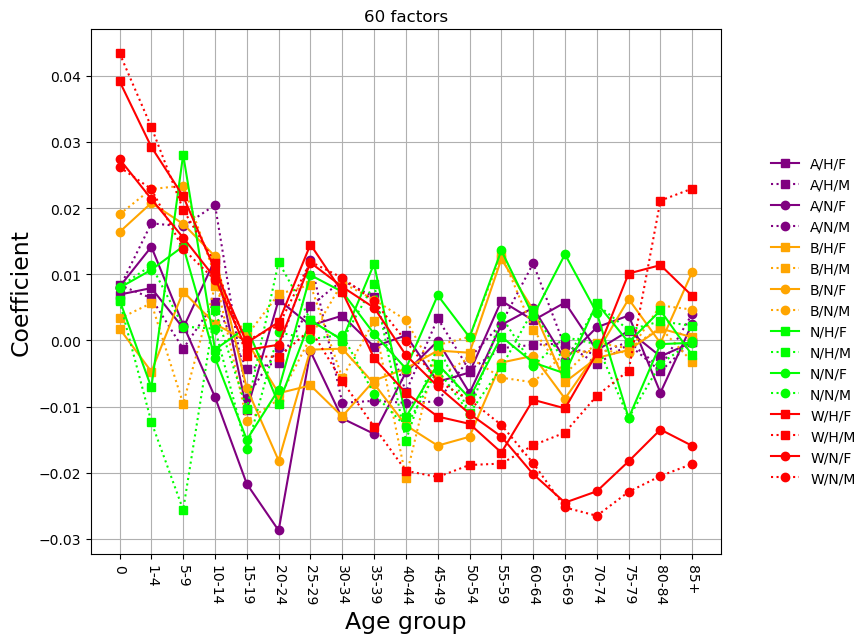

<Figure size 640x480 with 0 Axes>

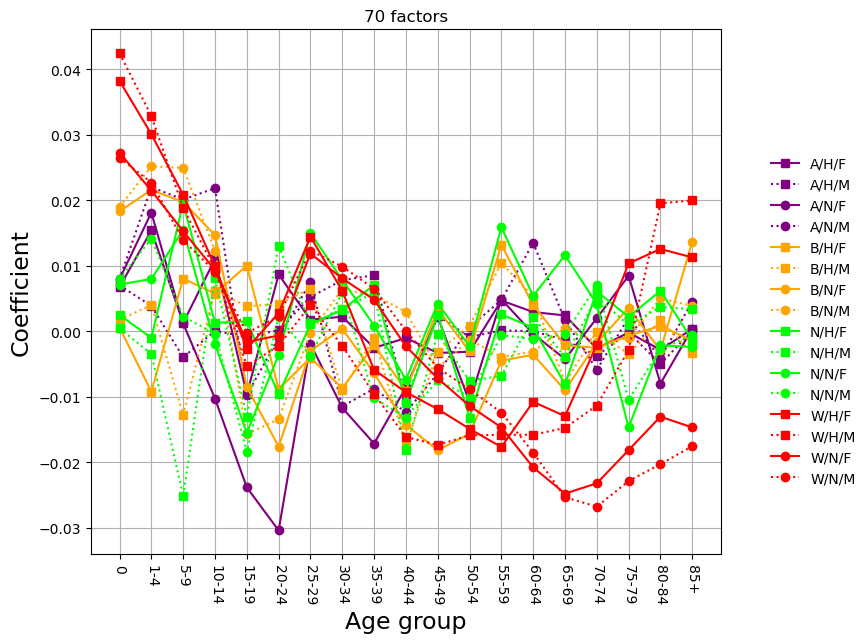

<Figure size 640x480 with 0 Axes>

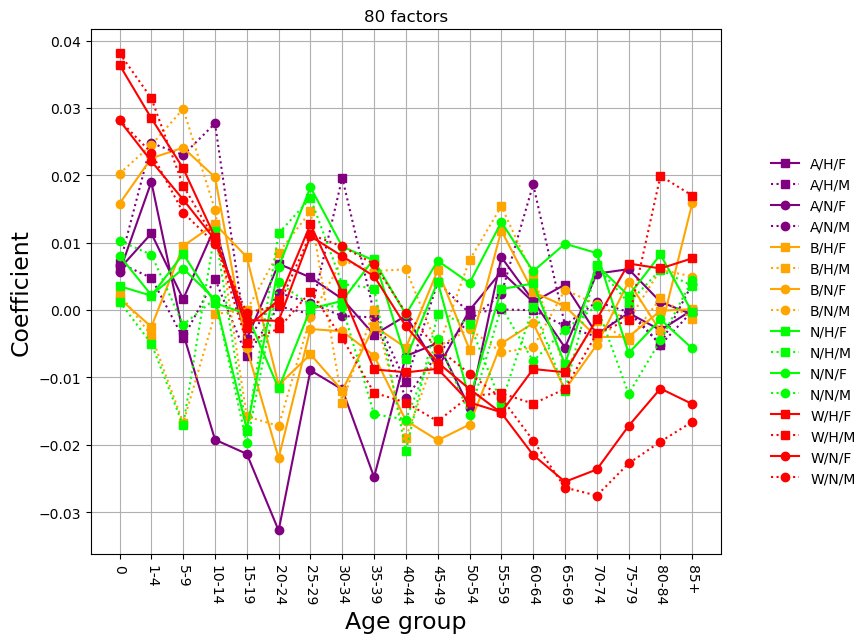

<Figure size 640x480 with 0 Axes>

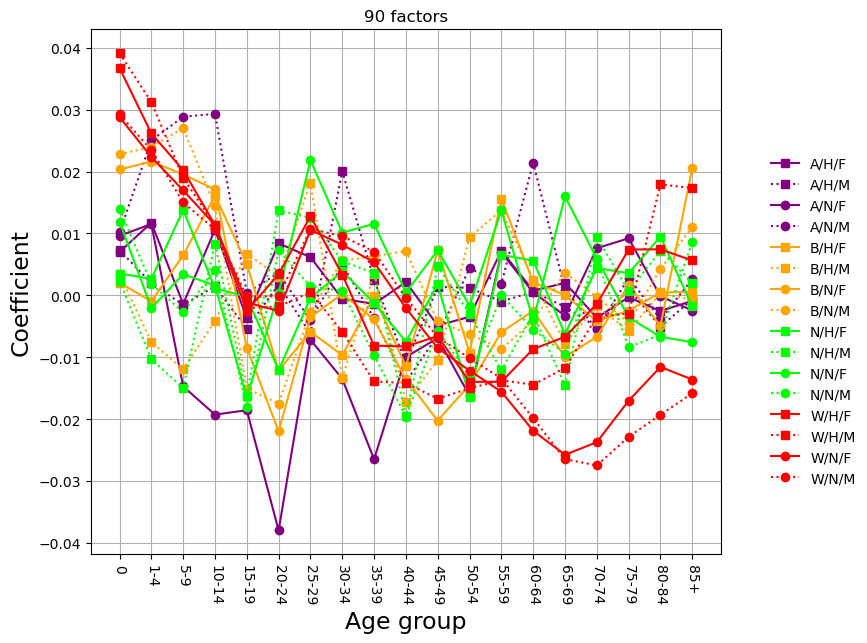

<Figure size 640x480 with 0 Axes>

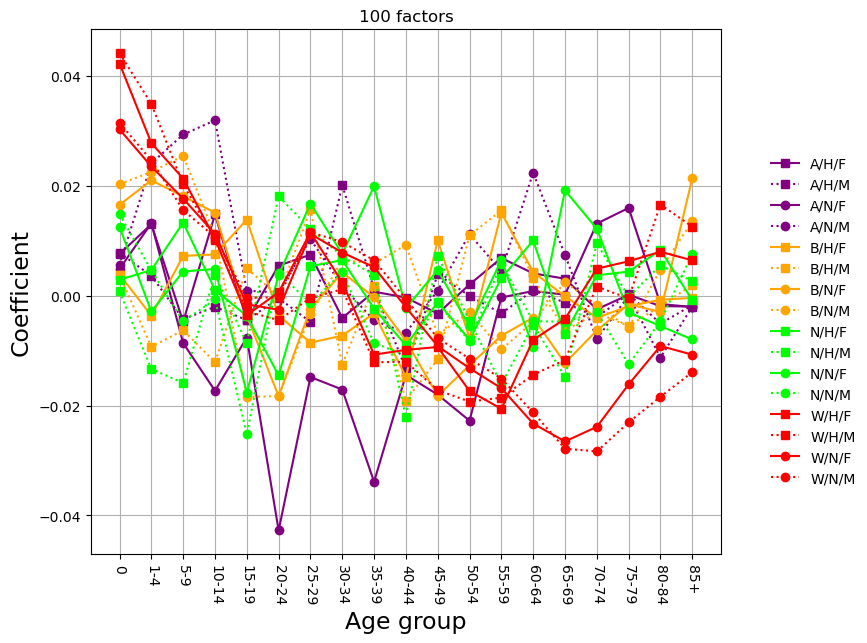

In [36]:
models = []
for npc in pcs:

    c, m, r = fitmodel(npc)
    models.append((m, r))

    plt.clf()
    plt.figure(figsize=(9, 7))
    ax = plt.axes([0.14, 0.18, 0.7, 0.75])
    ax.grid(True)
    for i in range(c.shape[0]):
        a = c.index[i]
        la = "/".join(a)
        ax.plot(ages, c.iloc[i, :], lt[a[2]] + sym[a[1]], color=colors[a[0]],
                label=la)

    # Setup the horizontal axis labels
    ax.set_xticks(ages)
    ax.set_xticklabels(age_groups)
    for x in plt.gca().get_xticklabels():
        x.set_rotation(-90)

    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)

    plt.xlabel("Age group", size=17)
    plt.ylabel("Coefficient", size=17)
    plt.title("%d factors" % npc)
    plt.show()

Use score tests to get a sense of the number of PC factors to include; also consider the PVEs calculated above.

In [37]:
for k in range(10):
    st = models[k+1][0].compare_score_test(models[k][1])
    print("%d versus %d: p=%f" % (pcs[k+1], pcs[k], st["p-value"]))

5 versus 0: p=0.000000
10 versus 5: p=0.000000
20 versus 10: p=0.000000
30 versus 20: p=0.000000
40 versus 30: p=0.062206
50 versus 40: p=0.030148
60 versus 50: p=0.001582
70 versus 60: p=0.243031
80 versus 70: p=0.007822
90 versus 80: p=0.328489
